# Problem Statement: IMDB Comment Sentiment Classifier

Dataset: For this exercise we will use a dataset hosted at http://ai.stanford.edu/~amaas/data/sentiment/

**Problem Statement**:
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well. Raw text and already processed bag of words formats are provided.

Launch a spark session, verify the spark session UI

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
print("Spark version: ", spark.version)

Spark version:  3.5.0


In [ ]:
spark.sparkContext.uiWebUrl

'http://7724551bbc06:4043'

IMDB comments dataset has been stored in the following location

In [ ]:
!wc -l data/imdb-comments.json

50000 data/imdb-comments.json


There are 50000 lines in the file. Let's the first line

In [ ]:
!du -sh data/imdb-comments.json

66M	data/imdb-comments.json


Total size of the file is 66MB

In [ ]:
!head -n 1 data/imdb-comments.json

{"label":"test","sentiment":"pos","name":"0_10.txt","content":"I went and saw this movie last night after being coaxed to by a few friends of mine. I'll admit that I was reluctant to see it because from what I knew of Ashton Kutcher he was only able to do comedy. I was wrong. Kutcher played the character of Jake Fischer very well, and Kevin Costner played Ben Randall with such professionalism. The sign of a good movie is that it can toy with our emotions. This one did exactly that. The entire theater (which was sold out) was overcome by laughter during the first half of the movie, and were moved to tears during the second half. While exiting the theater I not only saw many women in tears, but many full grown men as well, trying desperately not to let anyone see them crying. This movie was great, and I suggest that you go see it before you judge."}


Each line is a self contained json doc. Load the dataset using spark reader specifying the file format as json. As we see above size of the file is 66 MB, we should at least 2 partitons, since I am using dual core system, I will repartition the data to 4. Also will cache the data after repartitioning.

In [ ]:
imdb = spark.read.format("json").load("data/imdb-comments.json").repartition(4).cache()

Find total number of records

In [ ]:
imdb.count()

50000

Print Schema and view the field types

In [ ]:
imdb.printSchema()

root
 |-- content: string (nullable = true)
 |-- label: string (nullable = true)
 |-- name: string (nullable = true)
 |-- sentiment: string (nullable = true)



Take a look at a few sample data

In [ ]:
imdb.show()

+--------------------+-----+------------+---------+
|             content|label|        name|sentiment|
+--------------------+-----+------------+---------+
|Odd one should be...| test|12149_10.txt|      pos|
|This was a bold m...| test|   113_8.txt|      pos|
|I remember catchi...| test| 3272_10.txt|      pos|
|Some will say thi...| test|12377_10.txt|      pos|
|This Bravo specia...| test| 12025_9.txt|      pos|
|"Cat In The Brain...| test|  1511_9.txt|      pos|
|<br /><br />"Lets...| test|   384_9.txt|      pos|
|This is an action...| test|10694_10.txt|      pos|
|A small-town scho...| test|  2064_8.txt|      pos|
|I want to preface...| test|11288_10.txt|      pos|
|A gem of a cartoo...| test| 10021_9.txt|      pos|
|The "all I have i...| test|  3759_7.txt|      pos|
|I believe the rea...| test| 1860_10.txt|      pos|
|This is NOT the m...| test|  3862_8.txt|      pos|
|especially when l...| test| 2309_10.txt|      pos|
|Until I saw this ...| test| 3469_10.txt|      pos|
|An old man 

*label* - column indicate whethet the data belong to training or test bucket.
*sentiment* - column indicates whether the comment carries positive or negative sentiment. This column has been manually curated.

Find out for each combination of label and sentimnet how many records are there.

In [ ]:
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [ ]:
imdb.groupBy("sentiment").pivot("label").count().show()

+---------+-----+-----+
|sentiment| test|train|
+---------+-----+-----+
|      pos|12500|12500|
|      neg|12500|12500|
+---------+-----+-----+



Look at a sample comment value

In [ ]:
content = imdb.sample(False, 0.001, 1).first().content
content

"This is a well-crafted piece from everyone's favorite master of suspense. As usual, the technical elements such as camera work and lighting are outstanding (especially for the film's time). I did not find the first part of the film very exciting, but the latter one certainly made up for it with one thrilling scene after another.<br /><br />The only thing I did not like about this movie was the choice of Farley Granger for the part of Guy Haines. Somehow, I didn't find him very believable. On the other hand, Robert Walker shines as sinister 'bad guy' Bruno Anthony.<br /><br />Overall, I would highly recommend this."

Register a UDF function to clean the comment from the html tags. If BeautifulSoup is not installed, you can install it using pip

```(shell command)
$ pip install BeautifulSoup4
```

In [ ]:
from bs4 import BeautifulSoup
from pyspark.sql.types import *
import re
def remove_html_tags(text):
    text = BeautifulSoup(text, "html5lib").text.lower() #removed html tags
    text = re.sub("[\W]+", " ", text)
    return text

spark.udf.register("remove_html_tags", remove_html_tags, StringType())

<function __main__.remove_html_tags(text)>

Test the remove_html_tags function

In [ ]:
remove_html_tags(content)

'this is a well crafted piece from everyone s favorite master of suspense as usual the technical elements such as camera work and lighting are outstanding especially for the film s time i did not find the first part of the film very exciting but the latter one certainly made up for it with one thrilling scene after another the only thing i did not like about this movie was the choice of farley granger for the part of guy haines somehow i didn t find him very believable on the other hand robert walker shines as sinister bad guy bruno anthony overall i would highly recommend this '

Apply the the udf on the imdb dataframe.

In [ ]:
imdb_clean = imdb.withColumn("content", expr("remove_html_tags(content)")).cache()
imdb_clean.sample(False, 0.001, 1).first().content

'this is a well crafted piece from everyone s favorite master of suspense as usual the technical elements such as camera work and lighting are outstanding especially for the film s time i did not find the first part of the film very exciting but the latter one certainly made up for it with one thrilling scene after another the only thing i did not like about this movie was the choice of farley granger for the part of guy haines somehow i didn t find him very believable on the other hand robert walker shines as sinister bad guy bruno anthony overall i would highly recommend this '

Use Tokenizer to split the string into terms. Then use StopWordsRemover to remove stop words like prepositions, apply CountVectorizer to find all distinct terms and found of each term per document.

In [ ]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, CountVectorizer, StopWordsRemover

In [ ]:
tokenizer = Tokenizer(inputCol="content", outputCol="terms")
terms_data = tokenizer.transform(imdb_clean)

In [ ]:
print(terms_data.sample(False, 0.001, 1).first().terms)

['this', 'is', 'a', 'well', 'crafted', 'piece', 'from', 'everyone', 's', 'favorite', 'master', 'of', 'suspense', 'as', 'usual', 'the', 'technical', 'elements', 'such', 'as', 'camera', 'work', 'and', 'lighting', 'are', 'outstanding', 'especially', 'for', 'the', 'film', 's', 'time', 'i', 'did', 'not', 'find', 'the', 'first', 'part', 'of', 'the', 'film', 'very', 'exciting', 'but', 'the', 'latter', 'one', 'certainly', 'made', 'up', 'for', 'it', 'with', 'one', 'thrilling', 'scene', 'after', 'another', 'the', 'only', 'thing', 'i', 'did', 'not', 'like', 'about', 'this', 'movie', 'was', 'the', 'choice', 'of', 'farley', 'granger', 'for', 'the', 'part', 'of', 'guy', 'haines', 'somehow', 'i', 'didn', 't', 'find', 'him', 'very', 'believable', 'on', 'the', 'other', 'hand', 'robert', 'walker', 'shines', 'as', 'sinister', 'bad', 'guy', 'bruno', 'anthony', 'overall', 'i', 'would', 'highly', 'recommend', 'this']


In [ ]:
remover = StopWordsRemover(inputCol="terms", outputCol="filtered")
terms_stop_removed = remover.transform(terms_data)

In [ ]:
print(terms_stop_removed.sample(False, 0.001, 1).first().filtered)

['well', 'crafted', 'piece', 'everyone', 'favorite', 'master', 'suspense', 'usual', 'technical', 'elements', 'camera', 'work', 'lighting', 'outstanding', 'especially', 'film', 'time', 'find', 'first', 'part', 'film', 'exciting', 'latter', 'one', 'certainly', 'made', 'one', 'thrilling', 'scene', 'another', 'thing', 'like', 'movie', 'choice', 'farley', 'granger', 'part', 'guy', 'haines', 'somehow', 'didn', 'find', 'believable', 'hand', 'robert', 'walker', 'shines', 'sinister', 'bad', 'guy', 'bruno', 'anthony', 'overall', 'highly', 'recommend']


In [ ]:
count_vectorizer = CountVectorizer(inputCol="filtered", outputCol="count_vectors")
count_vectorizer_model = count_vectorizer.fit(terms_stop_removed)
count_vectorized = count_vectorizer_model.transform(terms_stop_removed)
count_vectorized.sample(False, 0.001, 1).first().count_vectors

SparseVector(103999, {0: 1.0, 1: 2.0, 2: 2.0, 3: 1.0, 5: 1.0, 10: 1.0, 12: 1.0, 17: 1.0, 18: 1.0, 43: 1.0, 53: 1.0, 59: 1.0, 64: 1.0, 65: 1.0, 71: 2.0, 76: 2.0, 105: 2.0, 154: 1.0, 186: 1.0, 243: 1.0, 266: 1.0, 301: 1.0, 312: 1.0, 332: 1.0, 403: 1.0, 406: 1.0, 424: 1.0, 487: 1.0, 542: 1.0, 635: 1.0, 683: 1.0, 700: 1.0, 705: 1.0, 981: 1.0, 1010: 1.0, 1019: 1.0, 1269: 1.0, 1375: 1.0, 1432: 1.0, 1766: 1.0, 1879: 1.0, 2701: 1.0, 2759: 1.0, 2844: 1.0, 3113: 1.0, 3132: 1.0, 3394: 1.0, 6063: 1.0, 6733: 1.0, 6960: 1.0})

count_vectorized Dataframe contains a column count_vectors that is a SparseVector representing which term appears and how many times. The key is the index of all unique terms. You can find list of terms count_vectorizer_model.vocabulary. See below.

In [ ]:
print(count_vectorizer_model.vocabulary[:100], "\n\nTotal no of terms", len(count_vectorizer_model.vocabulary))

['movie', 'film', 'one', 'like', 'good', 'time', 'even', 'story', 'really', 'see', 'well', 'much', 'bad', 'get', 'people', 'great', 'also', 'first', 'made', 'make', 'way', 'movies', 'characters', 'think', 'watch', 'character', 'films', 'two', 'many', 'seen', 'love', 'never', 'plot', 'life', 'acting', 'show', 'best', 'know', 'little', 'ever', 'man', 'better', 'end', 'scene', 'still', 'say', 'scenes', 've', 'something', 'm', 'go', 'back', 'real', 'thing', 'watching', 'actors', 're', 'doesn', 'director', 'didn', 'years', 'funny', 'though', 'old', 'another', 'work', '10', 'actually', 'nothing', 'makes', 'look', 'find', 'going', 'new', 'lot', 'every', 'part', 'world', 'cast', 'us', 'things', 'want', 'quite', 'pretty', 'horror', 'around', 'seems', 'young', 'take', 'however', 'big', 'got', 'thought', 'fact', 'enough', 'long', 'give', 'may', 'comedy', 'series'] 

Total no of terms 103999


In [ ]:
count_vectorized.show()

+--------------------+-----+------------+---------+--------------------+--------------------+--------------------+
|             content|label|        name|sentiment|               terms|            filtered|       count_vectors|
+--------------------+-----+------------+---------+--------------------+--------------------+--------------------+
|odd one should be...| test|12149_10.txt|      pos|[odd, one, should...|[odd, one, able, ...|(103999,[1,2,4,13...|
|this was a bold m...| test|   113_8.txt|      pos|[this, was, a, bo...|[bold, movie, hit...|(103999,[0,4,17,2...|
|i remember catchi...| test| 3272_10.txt|      pos|[i, remember, cat...|[remember, catchi...|(103999,[1,2,5,7,...|
|some will say thi...| test|12377_10.txt|      pos|[some, will, say,...|[say, movie, guil...|(103999,[0,2,9,10...|
|this bravo specia...| test| 12025_9.txt|      pos|[this, bravo, spe...|[bravo, special, ...|(103999,[2,8,10,1...|
| cat in the brain...| test|  1511_9.txt|      pos|[, cat, in, the, ...|[, cat, 

SparkVector represents a vector of 103999, that means in the dataset (corpus) there are 103999 unique terms. Per document, only a few will be present. Find density of each count_vectors.

In [ ]:
vocab_len = len(count_vectorizer_model.vocabulary)
spark.udf.register("density", lambda r: r.numNonzeros() / vocab_len, DoubleType())
count_vectorized.select(expr("density(count_vectors) density")).show()

+--------------------+
|             density|
+--------------------+
|7.692381657515938E-4|
|4.807738535947461E-4|
|7.500072116078039E-4|
|8.557774593986481E-4|
|0.001000009615477072|
|0.002019250185097...|
| 8.65392936470543E-4|
|5.480821930980105E-4|
| 6.15390532601275E-4|
|0.001355782267137184|
|5.096202848104309E-4|
|  6.0577505552938E-4|
|5.096202848104309E-4|
| 8.75008413542438E-4|
|3.942345599476918E-4|
|4.519274223790613...|
|0.001048087000836...|
|0.001682708487581...|
|0.001663477533437...|
|9.711631842613871E-4|
+--------------------+
only showing top 20 rows



Density report shows, the count_vectors has very low density which illustrate the benefit of the choice of DenseVector for this column.

Now, calculate tfidf for the document.

In [ ]:
idf = IDF(inputCol="count_vectors", outputCol="features")
idf_model = idf.fit(count_vectorized)
idf_data = idf_model.transform(count_vectorized)

In [ ]:
idf_data.sample(False, 0.001, 1).first().features

SparseVector(103999, {0: 0.4923, 1: 1.1769, 2: 1.1288, 3: 0.7696, 5: 1.0595, 10: 1.2039, 12: 1.445, 17: 1.3774, 18: 1.3927, 43: 1.8644, 53: 1.8957, 59: 1.9746, 64: 1.9455, 65: 1.9844, 71: 3.9905, 76: 4.1484, 105: 4.7715, 154: 2.4115, 186: 2.5508, 243: 2.8292, 266: 2.7288, 301: 2.9121, 312: 2.9356, 332: 2.9337, 403: 3.1597, 406: 3.1806, 424: 3.1649, 487: 3.4414, 542: 3.3873, 635: 3.6068, 683: 3.6082, 700: 3.5965, 705: 3.6171, 981: 3.9591, 1010: 3.9771, 1019: 4.1352, 1269: 4.2078, 1375: 4.3413, 1432: 4.3583, 1766: 4.5992, 1879: 4.7843, 2701: 5.036, 2759: 5.5417, 2844: 5.143, 3113: 5.1994, 3132: 5.2177, 3394: 6.1377, 6063: 6.8125, 6733: 6.8686, 6960: 7.1562})

In [ ]:
idf_data.printSchema()

root
 |-- content: string (nullable = true)
 |-- label: string (nullable = true)
 |-- name: string (nullable = true)
 |-- sentiment: string (nullable = true)
 |-- terms: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- count_vectors: vector (nullable = true)
 |-- features: vector (nullable = true)



Apply StringIndexer to conver the sentiment column from String type to number type - this is prerequisit to apply the LogisticRegression algorithm.

In [ ]:
from pyspark.ml.feature import StringIndexer

In [ ]:
string_indexer = StringIndexer(inputCol="sentiment", outputCol="sentiment_idx")
string_indexer_model = string_indexer.fit(idf_data)
label_encoded = string_indexer_model.transform(idf_data)

In [ ]:
label_encoded.select("sentiment", "sentiment_idx").show()

+---------+-------------+
|sentiment|sentiment_idx|
+---------+-------------+
|      pos|          1.0|
|      pos|          1.0|
|      pos|          1.0|
|      pos|          1.0|
|      pos|          1.0|
|      pos|          1.0|
|      pos|          1.0|
|      pos|          1.0|
|      pos|          1.0|
|      pos|          1.0|
|      pos|          1.0|
|      pos|          1.0|
|      pos|          1.0|
|      pos|          1.0|
|      pos|          1.0|
|      pos|          1.0|
|      pos|          1.0|
|      pos|          1.0|
|      pos|          1.0|
|      pos|          1.0|
+---------+-------------+
only showing top 20 rows



Split the data into traininf and testing groups with 70/30 ratio. Cache the dataframe so that training runs faster.

In [ ]:
training, testing = label_encoded.randomSplit(weights=[0.7, 0.3], seed=1)
training.cache()
testing.cache()

DataFrame[content: string, label: string, name: string, sentiment: string, terms: array<string>, filtered: array<string>, count_vectors: vector, features: vector, sentiment_idx: double]

Verify that the StringIndex has done the expected job and training and testing data maintain the ratio of positive and negative records as in the whole dataset.

In [ ]:
training.groupBy("sentiment_idx", "sentiment").count().show()

+-------------+---------+-----+
|sentiment_idx|sentiment|count|
+-------------+---------+-----+
|          1.0|      pos|17478|
|          0.0|      neg|17580|
+-------------+---------+-----+



In [ ]:
testing.groupBy("sentiment_idx", "sentiment").count().show()

+-------------+---------+-----+
|sentiment_idx|sentiment|count|
+-------------+---------+-----+
|          1.0|      pos| 7522|
|          0.0|      neg| 7420|
+-------------+---------+-----+



Apply LogisticRegression classifier

In [ ]:
from pyspark.ml.classification import LogisticRegression

In [ ]:
lr = LogisticRegression(maxIter=10000, regParam=0.1, elasticNetParam=0.0,
                        featuresCol="features", labelCol="sentiment_idx")

Show the parameters that the LogisticRegression classifier takes.

In [ ]:
print(lr.explainParams())

aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0, current: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features, current: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label, current: sentiment_idx)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
lowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constra

In [ ]:
lr_model = lr.fit(training)

In [ ]:
lr_model.coefficients[:100]

array([-0.02150835,  0.00417042,  0.00401378, -0.01826718,  0.03075211,
        0.01063359, -0.05089962,  0.01179903,  0.00110723,  0.04364796,
        0.05994775, -0.02042877, -0.10395758, -0.00446455,  0.00726763,
        0.11661861,  0.0331274 ,  0.01636061, -0.01979377, -0.0327325 ,
        0.00124368, -0.00323632, -0.00704873,  0.02582459,  0.01076965,
       -0.00478519,  0.00983704,  0.00254332,  0.014075  ,  0.01518147,
        0.04702795, -0.005658  , -0.04672264,  0.02558984, -0.04867136,
        0.00421845,  0.0756486 ,  0.00053645,  0.01018614, -0.01157225,
        0.00974906, -0.040202  ,  0.00272038, -0.00587066,  0.04725849,
        0.00055563, -0.00031392, -0.00589728, -0.02307934, -0.01733307,
        0.00695628,  0.01145825,  0.01842606, -0.03949737, -0.02455343,
       -0.02351036, -0.01025862, -0.02322132, -0.02799538, -0.02949059,
        0.02688718,  0.00880627,  0.01570644, -0.00464354, -0.01322802,
       -0.00141047,  0.01927606, -0.0137245 , -0.07128185,  0.03

From the training summary find out the cost decay of the model.

In [ ]:
training_summary = lr_model.summary

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

Text(0, 0.5, 'Cost')

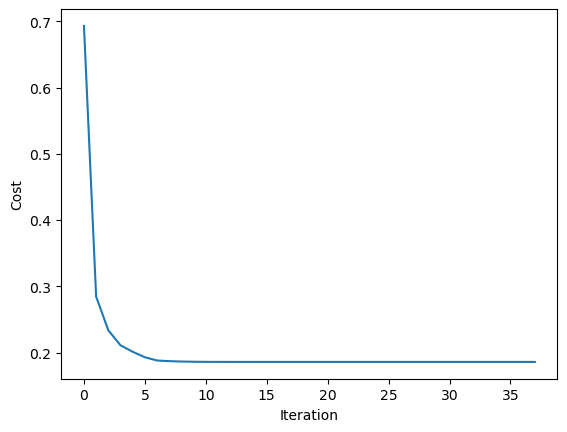

In [ ]:
pd.Series(training_summary.objectiveHistory).plot()
plt.xlabel("Iteration")
plt.ylabel("Cost")

Find area under the curve. Closer to 1 is better

In [ ]:
training_summary.areaUnderROC

0.9998898582856833

In [ ]:
predictions = lr_model.transform(testing).withColumn("match", expr("prediction == sentiment_idx"))

In [ ]:
predictions.select("prediction", "sentiment_idx", "sentiment", "match").sample(False, 0.01).show(10)

+----------+-------------+---------+-----+
|prediction|sentiment_idx|sentiment|match|
+----------+-------------+---------+-----+
|       0.0|          1.0|      pos|false|
|       0.0|          0.0|      neg| true|
|       0.0|          0.0|      neg| true|
|       0.0|          1.0|      pos|false|
|       0.0|          1.0|      pos|false|
|       0.0|          0.0|      neg| true|
|       0.0|          1.0|      pos|false|
|       0.0|          0.0|      neg| true|
|       1.0|          1.0|      pos| true|
|       0.0|          0.0|      neg| true|
+----------+-------------+---------+-----+
only showing top 10 rows



In [ ]:
predictions.groupBy("sentiment_idx").pivot("prediction").count().show()

+-------------+----+----+
|sentiment_idx| 0.0| 1.0|
+-------------+----+----+
|          0.0|6504| 916|
|          1.0| 735|6787|
+-------------+----+----+



Find the accuracy of the prediction

In [ ]:
accuracy = predictions.select(expr("sum(cast(match as int))")).first()[0] / predictions.count()
accuracy

0.8895060902155